<a href="https://colab.research.google.com/github/sverdoot/optimizer-SUG-torch/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Optimization project")
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Optimization project'

In [0]:
from sug import SUG
from usage import time_since
from usage import model_step

In [0]:
import torch
from torch.optim import Optimizer
import math


class SUG(Optimizer):
    def __init__(self, params, l_0, d_0=0, prob=1., eps=1e-3, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if l_0 < 0.0:
            raise ValueError("Invalid Lipsitz constant of gradient: {}".format(l_0))
        if d_0 < 0.0:
            raise ValueError("Invalid disperion of gradient: {}".format(d_0))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(L=l_0, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        self.Lips = l_0
        self.prev_Lips = l_0
        self.D_0 = d_0
        self.eps = eps
        self.prob = prob
        self.start_param = params
        self.loss = torch.tensor(0.)
        self.closure = None
        super(SUG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SUG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def comp_batch_size(self):
        """Returns optimal batch size for given d_0, eps and l_0;

        """
        return math.ceil(2 * self.D_0 * self.eps / self.prev_Lips)

    def step(self, loss, closure):
        """Performs a single optimization step.

        Arguments:
            loss : current loss

            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        self.start_param = []
        self.loss = loss
        self.closure = closure
        check = torch.bernoulli(torch.tensor(float(self.prob))).item()
        # self.L = min(self.L / 2, 2)
        for gr_idx, group in enumerate(self.param_groups):
            # weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p_idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                self.start_param.append({'data': p.data.clone(), 'grad': p.grad.data.clone()})
                d_p = self.start_param[-1]['grad']
                # p_ = self.start_param[-1]['data']
                # if weight_decay != 0:
                #    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
        i = 0
        difference = -1
        while difference < 0:
            if check:
                self.Lips = max(self.prev_Lips * 2 ** (i - 1), 2.)
            for j, p in enumerate(self.start_param):
                self.param_groups[0]['params'][j].data = p['data'] - 1 / (2 * self.Lips) * p['grad']
            if check:
                difference, upd_loss = self.stop_criteria()
            else:
                difference = 1
            i += 1
        self.prev_Lips = self.Lips

        return self.Lips, i

    def stop_criteria(self):
        """Checks if the Lipsitz constant of gradient is appropriate
        """
        cur_loss = self.loss.item()
        upd_loss = self.closure().item()
        #linear_part, quadratic_part = 0, 0
        delta = 0.
        for j, p in enumerate(self.start_param):
            #delta = (self.param_groups[0]['params'][j].data - p['data'])
            #linear_part += torch.sum(p['grad'] * delta)
            #quadratic_part += torch.sum(delta * delta)
            delta += torch.sum(p['grad'] * p['grad'])
        """ <g(x_k), w_k - x_k> + 2L_k / 2 ||x_k - w_k||^2 = - 1 / (2L_k)||g(x_k)||^2 + 1 / (4L_k)||g(x_k)||^2 = -1 / (4L_k)||g(x_k)||^2
        """
        major =  cur_loss - 1 / (4 * self.Lips) * delta
        #return cur_loss - upd_loss + linear_part + self.Lips * quadratic_part + self.eps / 10, upd_loss
        return major - upd_loss + self.eps / 10, upd_loss

    def get_lipsitz_const(self):
        """ Returns current Lipsitz constant of the gradient of the loss function
        """
        return self.Lips


In [0]:
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import time
import pandas as pd
import numpy as np

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

## Data

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
batch_size = 4

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
trainloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [0]:
batchs_per_epoch = 50000 // batch_size

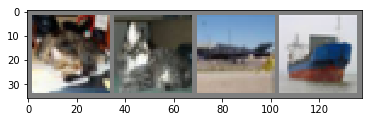

  cat	  cat	plane	 ship


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\t'.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train

In [0]:
import time
import math


def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def model_step(model, optimizer, criterion, inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
    if optimizer.__class__.__name__ != 'SUG':
        optimizer.step()
    else:
        def closure():
            optimizer.zero_grad()
            upd_outputs = model(inputs)
            upd_loss = criterion(upd_outputs, labels)
            upd_loss.backward(retain_graph=True)
            return upd_loss

        optimizer.step(loss, closure)

    return loss.item()

In [0]:
def train(model, trainloader, criterion, optimizer, n_epochs=2, eps=1e-5, print_every=1):
    losses = []
    start_time = time.time()
    model.to(device=device).train()
    for ep in range(n_epochs):
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            losses.append(model_step(model, optimizer, criterion, inputs, labels))

        if ep % print_every == 0:
            print("Epoch {}, loss {}, time passed {}".format(ep, sum(losses[-i:]) / i, time_since(start_time)))
        
    return losses

In [0]:
def train_lips(model, trainloader, criterion, optimizer, n_epochs=2, eps=1e-5, print_every=1):
    losses = []
    lips = []
    start_time = time.time()
    model.to(device).train()
    for ep in range(n_epochs):
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            losses.append(model_step(model, optimizer, criterion, inputs, labels))
            lips.append(optimizer.get_lipsitz_const())
        
        if ep % print_every == 0:
            print("Epoch {}, loss {}, time passed {}".format(ep, sum(losses[-i:]) / i, time_since(start_time)))
            print("Lipsitz constant {}".format(optimizer.get_lipsitz_const()))

    return losses, lips

In [0]:
print_every = 1
n_epochs = 15
losses = {}
losses['sgd'] = {}
lrs = [0.01, 0.001]
criterion = nn.CrossEntropyLoss(reduction="mean")

In [19]:
for lr in lrs:
  print("Trining for SGD lr={}, momentum=0.".format(lr))
  net = Net()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.)
  losses['sgd'][lr] = train(net, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every)

Trining for SGD lr=0.01, momentum=0.
Epoch 0, loss 1.689263466060405, time passed 0m 53s
Epoch 1, loss 1.334130160884291, time passed 1m 41s
Epoch 2, loss 1.2098840361609917, time passed 2m 27s
Epoch 3, loss 1.1118617537417634, time passed 3m 14s
Epoch 4, loss 1.040202680843164, time passed 4m 0s
Epoch 5, loss 0.9790666924923818, time passed 4m 47s
Epoch 6, loss 0.9362179746684269, time passed 5m 33s
Epoch 7, loss 0.8978988984096755, time passed 6m 21s
Epoch 8, loss 0.8640562053565665, time passed 7m 9s
Epoch 9, loss 0.8310008965756323, time passed 7m 56s
Epoch 10, loss 0.8049570134720122, time passed 8m 43s
Epoch 11, loss 0.7830205745163493, time passed 9m 30s
Epoch 12, loss 0.7583162115424984, time passed 10m 17s
Epoch 13, loss 0.746174738947244, time passed 11m 5s
Epoch 14, loss 0.725915546848427, time passed 11m 51s
Trining for SGD lr=0.001, momentum=0.
Epoch 0, loss 2.2622463924139535, time passed 0m 48s
Epoch 1, loss 1.9668754809464881, time passed 1m 34s
Epoch 2, loss 1.65675038

In [0]:
l_0 = 2

In [43]:
net = Net()
optimizer = SUG(net.parameters(), l_0=l_0, momentum=0.)
losses['sug'], lips = train_lips(net, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, eps=0.1)

Epoch 0, loss 1.7143023236578623, time passed 1m 43s
Lipsitz constant 32.0
Epoch 1, loss 1.4451231452067077, time passed 3m 28s
Lipsitz constant 16.0
Epoch 2, loss 1.318764834072468, time passed 5m 11s
Lipsitz constant 8.0
Epoch 3, loss 1.2155641278478373, time passed 6m 54s
Lipsitz constant 16.0
Epoch 4, loss 1.1287842620033313, time passed 8m 38s
Lipsitz constant 32.0
Epoch 5, loss 1.0585312964663676, time passed 10m 20s
Lipsitz constant 16.0
Epoch 6, loss 1.0006715831675332, time passed 12m 2s
Lipsitz constant 32.0
Epoch 7, loss 0.9348258920450842, time passed 13m 46s
Lipsitz constant 128.0
Epoch 8, loss 0.8804046149391758, time passed 15m 27s
Lipsitz constant 32.0
Epoch 9, loss 0.827149204539627, time passed 17m 10s
Lipsitz constant 32.0
Epoch 10, loss 0.7739877490265216, time passed 18m 54s
Lipsitz constant 128.0
Epoch 11, loss 0.7206265276904602, time passed 20m 38s
Lipsitz constant 256.0
Epoch 12, loss 0.6779930478706867, time passed 22m 22s
Lipsitz constant 128.0
Epoch 13, loss

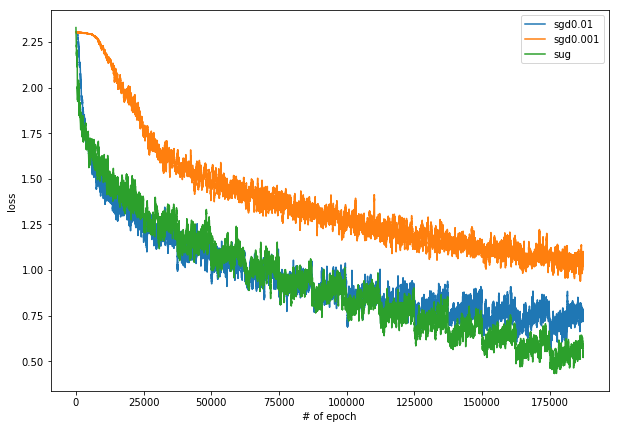

In [41]:
figure = plt.figure(figsize=(10,7))
for lr in lrs:
    plt.plot([np.mean(losses['sgd'][lr][i:i+200]) for i in range(len(losses['sgd'][lr])-200)], label='sgd'+str(lr))
plt.plot([np.mean(losses['sug'][i:i+200]) for i in range(len(losses['sug'])-200)], label="sug")
plt.xlabel("# of batch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [79]:
batchs_per_epoch

12500

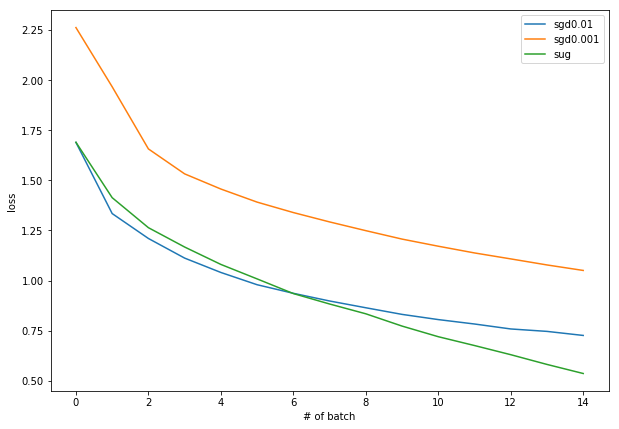

In [83]:
figure = plt.figure(figsize=(10,7))
for lr in lrs:
    plt.plot([sum(losses['sgd'][lr][i*batchs_per_epoch:(i+1)*batchs_per_epoch])/batchs_per_epoch for i in range(n_epochs)], label='sgd'+str(lr))
plt.plot([sum(losses['sug'][i*batchs_per_epoch:(i+1)*batchs_per_epoch])/batchs_per_epoch for i in range(n_epochs)], label="sug")
plt.xlabel("# of batch")
plt.ylabel("loss")
plt.legend()
plt.show()

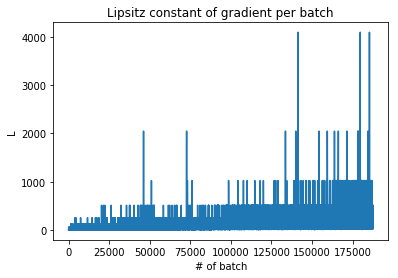

In [44]:
plt.plot(lips)
plt.title("Lipsitz constant of gradient per batch")
plt.xlabel("# of batch")
plt.ylabel("L")
#plt.legend()
plt.show()

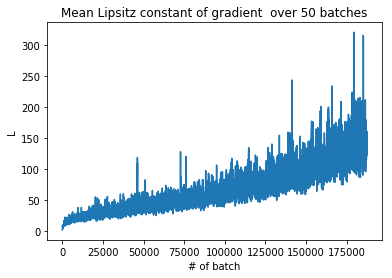

In [45]:
smooth_over = 50
smooth_lips = [np.mean(lips[i:i+smooth_over]) for i in range(len(lips)-smooth_over)]

plt.plot(smooth_lips)
plt.title("Mean Lipsitz constant of gradient  over {} batches".format(smooth_over))
plt.xlabel("# of batch")
plt.ylabel("L")
#plt.legend()
plt.show()

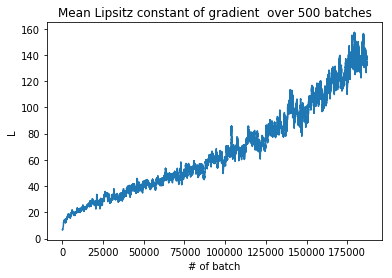

In [46]:
smooth_over = 500
smooth_lips = [np.mean(lips[i:i+smooth_over]) for i in range(len(lips)-smooth_over)]

plt.plot(smooth_lips)
plt.title("Mean Lipsitz constant of gradient  over {} batches".format(smooth_over))
plt.xlabel("# of batch")
plt.ylabel("L")
#plt.legend()
plt.show()

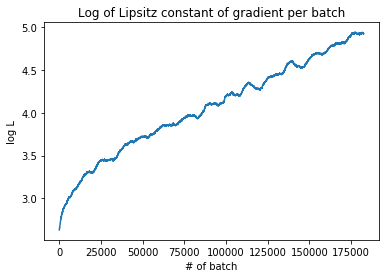

In [47]:
smooth_over = 5000
smooth_lips = [np.mean(lips[i:i+smooth_over]) for i in range(len(lips)-smooth_over)]

plt.plot(np.log(smooth_lips))
plt.title("Log of Lipsitz constant of gradient per batch")
plt.xlabel("# of batch")
plt.ylabel("log L")
#plt.legend()
plt.show()

## + momentum

## Test

In [0]:
def test(model, trainloader, criterion, optimizer, eps=1e-5, print_every=1):
    losses = []
    start_time = time.time()
    model.to(device=device).eval()
    for ep in range(n_epochs):
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            losses.append(model_step(model, optimizer, criterion, inputs, labels))

        if ep % print_every == 0:
            print("Epoch {}, loss {}, time passed {}".format(ep, sum(losses[-i:]) / i, time_since(start_time)))
    return losses

In [0]:
from sklearn.metrics import f1_score

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))